# **TRAINING**

### Initial configurations

In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

E0000 00:00:1732386595.972247      77 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1123 18:29:55.980313760      77 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1123 18:29:55.980328624      77 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1123 18:29:55.980332711      77 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1123 18:29:55.980335404      77 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1123 18:29:55.980338217      77 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

In [3]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

### Set accelerator

In [4]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [5]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1732386635.015308      77 service.cc:145] XLA service 0x59896ed7d6f0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732386635.015360      77 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732386635.015364      77 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732386635.015368      77 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732386635.015372      77 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732386635.015376      77 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732386635.015380      77 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732386635.015384      77 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732386635.015388      77 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU: 
Running on 8 replicas
Num GPUs Available:  0
Num TPUs Available:  8


In [6]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256


## **DATA PREPROCESSING**

In [7]:
train_path = "/kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz"
val_path = "/kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz"
print(f"reading {train_path}")
print(f"reading {val_path}")

reading /kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz
reading /kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz


In [8]:
data_train = np.load(train_path, allow_pickle=True)
X_train = data_train['images']
y_train = data_train['labels']

data_val = np.load(val_path, allow_pickle=True)
X_val = data_val['images']
y_val = data_val['labels']

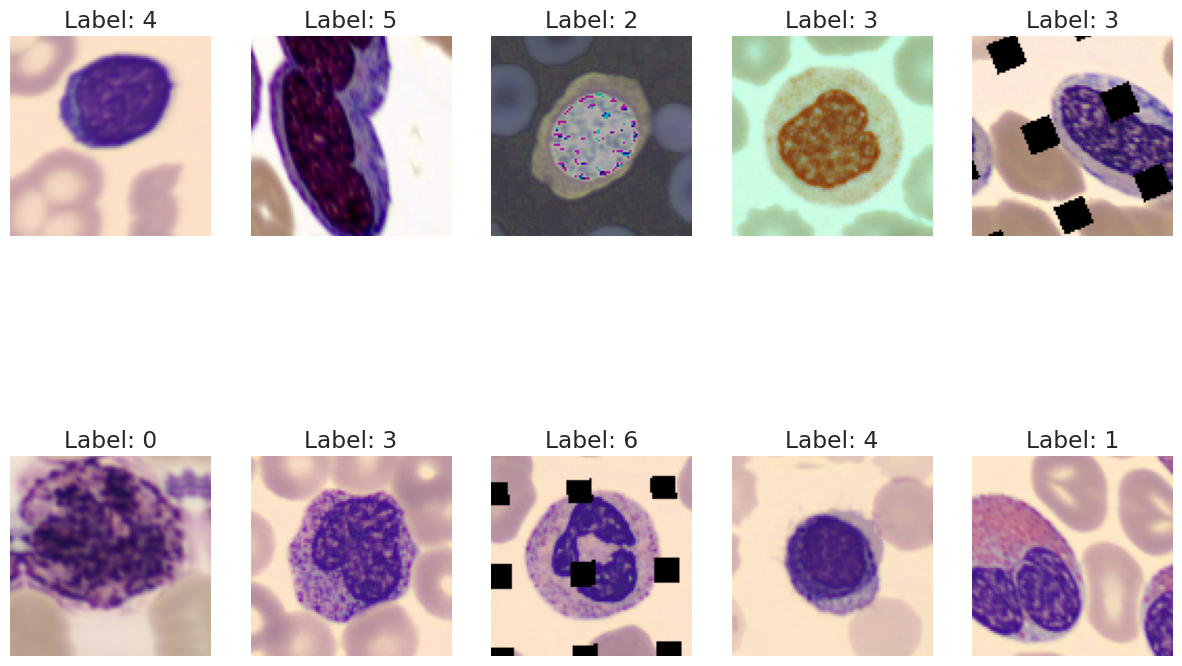

In [9]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[random_idx])
    plt.title(f"Label: {np.argmax(y_train[random_idx])}")
    plt.axis('off')
plt.show()

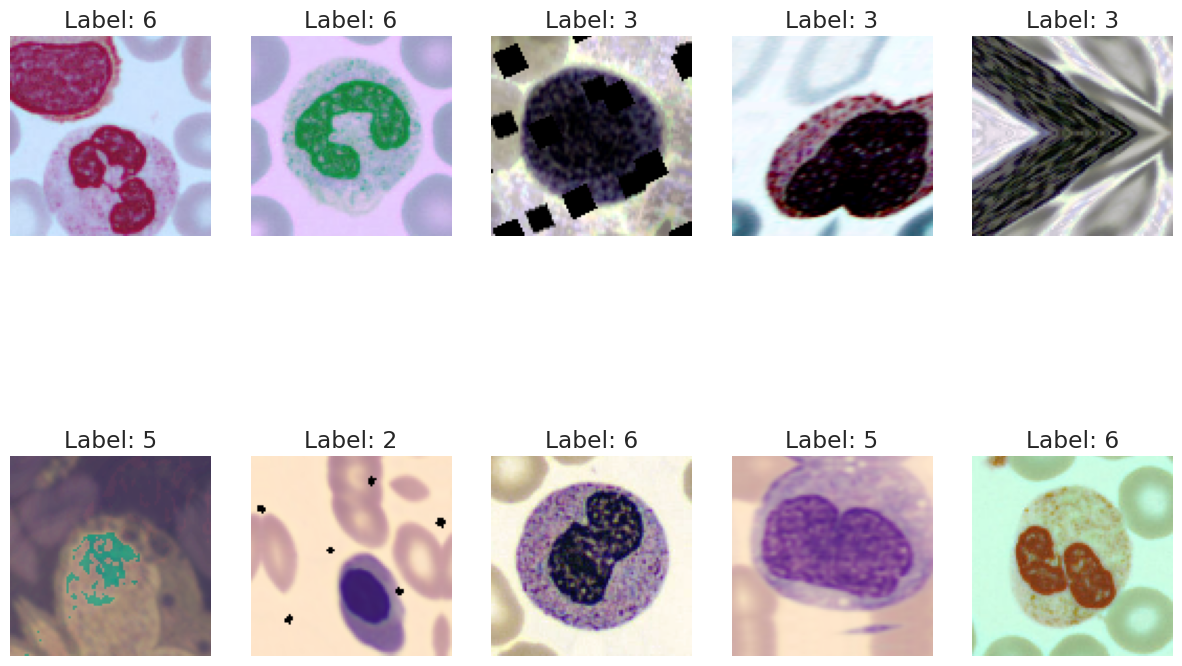

In [10]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_val.shape[0])
    plt.imshow(X_val[random_idx])
    plt.title(f"Label: {np.argmax(y_val[random_idx])}")
    plt.axis('off')
plt.show()

In [11]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (91431, 96, 96, 3)
Training Label Shape: (91431, 8)
Validation Data Shape: (16137, 96, 96, 3)
Validation Label Shape: (16137, 8)


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(65536).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Custom callbacks

In [13]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [14]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [15]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

### Model definition

In [16]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  357


In [17]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

@register_keras_serializable()
class CustomAugmentLayer(tfk.layers.Layer):
    def __init__(self, max_rotation=30.0, max_zoom=0.2, **kwargs):
        super(CustomAugmentLayer, self).__init__(**kwargs)
        self.max_rotation = max_rotation / 360.0
        self.max_zoom = max_zoom
        
    def call(self, inputs, training=False):
        if training:
            inputs = tf.image.random_flip_up_down(tf.image.random_flip_left_right(inputs))
        return inputs


In [18]:
def build_model(
            shape=input_shape, 
            n_labels=output_shape, 
            base_model_trainable=False, #standard definitions
            n_dense_layers=1, 
            initial_dense_neurons=1024, 
            min_neurons=64, # architecture definitions
            include_dropout=True, 
            dropout_rate=0.3, 
            l2_lambda=4e-3, # against overfitting
            learning_rate=1e-3,
            mult_next_layer = 1/2,
            include_batch_normalization = True):
    
    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')   
    
    # The two augmentation layers
    x = CustomCastLayer()(inputs)
    x = CustomAugmentLayer()(x, training=True)

    # The convnext layer with include top=False to take the convolutional part only
    base_model = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    base_model.trainable = base_model_trainable

    x = base_model(x)
    x = tfkl.BatchNormalization(name="BatchNorm_After_ConvNeXt")(x) if include_batch_normalization else x # BatchNorm after ConvNeXt
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation=None, name=f'Dense_layer_{k}', 
                       kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        x = tfkl.BatchNormalization(name=f'BatchNorm_Dense_layer_{k}')(x) if include_batch_normalization else x   # BatchNorm in dense layer
        x = tfkl.Activation('silu', name=f'Activation_layer_{k}')(x)  # Apply activation after BatchNorm
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = int(neurons * mult_next_layer)

    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalFocalCrossentropy(
                                                alpha=0.25,
                                                gamma=2.0,
                                                from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="sum_over_batch_size",
                                                name="categorical_focal_crossentropy",
                                                dtype=None,
                                            )
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tf.keras.optimizers.AdamW(
                                learning_rate=learning_rate,
                                weight_decay=l2_lambda,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                use_ema=False,
                                ema_momentum=0.99,
                                name="adamw"
                            )
                                
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model


## **TRANSFER LEARNING**

In [19]:
# Best values found so far
n_dense_layers = 5
initial_dense_neurons = 1943
dropout_rate = 0.4
l2_lambda = 5e-5
learning_rate = 1.59608e-5
mult_next_layer = 0.44626
include_batch_normalization = True

epochs = 500

In [20]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = build_model(
            base_model_trainable=False,
            n_dense_layers=n_dense_layers,
            initial_dense_neurons=initial_dense_neurons,
            include_dropout=True,
            dropout_rate=dropout_rate,
            l2_lambda=l2_lambda,
            learning_rate=learning_rate,
            mult_next_layer=mult_next_layer,
            include_batch_normalization = include_batch_normalization
        )

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

I0000 00:00:1732386722.567501      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


         0/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

   4202496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

  12173312/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

  17956864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

  26214400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

  37666816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

  41951232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

  55328768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step 

  61505536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

  71450624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

  80224256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

  85696512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

  95379456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 104038400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 110723072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 119242752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 127475712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 130351104/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 133890048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 139960320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 145727488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 153313280/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 162840576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 167501824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 175366144/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 187400192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 192987136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 201244672/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 212434944/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 219791360/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 231374848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 243277824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 253304832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 264101888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 273326080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 277667840/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 279199744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 286400512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 288440320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 298729472/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 300589056/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 305266688/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 314269696/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 323813376/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 326574080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 330506240/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 337887232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 338493440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 341278720/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 342294528/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 347586560/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 351272960/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 354541568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 356884480/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 361676800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 363118592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 369811456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 370229248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 371703808/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 372023296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 377323520/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 384221184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 385867776/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 389095424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 397123584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 407019520/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 407511040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 410574848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 413220864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 417931264/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 421511168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 425459712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 430407680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 436723712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 444727296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 447381504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 447946752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 448356352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 448757760/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 449658880/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 450306048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 450781184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 455720960/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 456105984/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 457498624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 459071488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 461479936/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 462323712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 466968576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 469917696/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 477192192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 486547456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 489275392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 494911488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 496967680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 497688576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 501620736/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 507453440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 511770624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 516956160/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 520159232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 523157504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 525500416/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 535363584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 540147712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 545161216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 547749888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 552321024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 555442176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 558014464/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 560832512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 562847744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 567902208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 573775872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 578822144/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 587210752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 598540288/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 605470720/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 612376576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 620765184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 632823808/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 639795200/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 648544256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 656777216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 662708224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 672718848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 683646976/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 693248000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 700932096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 710148096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 720912384/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 730472448/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 739999744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 751673344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 763445248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 776462336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 787685376/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 799047680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 808902656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 817004544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 824844288/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 835354624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 845242368/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 855646208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 864731136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 874364928/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 879443968/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 884940800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 893698048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 906207232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 917635072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 929062912/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 941350912/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 951631872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 962420736/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 974626816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 986595328/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 998350848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1011793920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1022058496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1032298496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1041358848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1052147712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1063944192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1075552256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1084489728/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1089167360/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1096630272/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1098997760/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1100578816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1102512128/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1107689472/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1116397568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1119682560/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1128218624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1134862336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1138450432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1140596736/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1146724352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1150099456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1151483904/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1153409024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1157292032/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1161076736/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1165402112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1173757952/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1185939456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1192058880/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1193828352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1201160192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1208279040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1214898176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1226096640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1238712320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1252671488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1264910336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1274175488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1277296640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1279574016/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1283383296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1287405568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1289863168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1292320768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1299226624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1302855680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1312243712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1318027264/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1324867584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1331093504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1341874176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1345282048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1347813376/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1351229440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1353080832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1363771392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1371332608/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1381982208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1387462656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ cast (Cast)                 │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_cast_layer           │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomCastLayer)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_augment_layer        │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomAugmentLayer)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_xlarge             │ (None, 3, 3, 2048)    │ 348,147,9… │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_After_ConvNeXt    │ (None, 3, 3, 2048)    │      8,192 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_0 (Dense)       │ (None, 1943)          │  3,981,207 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_0     │ (None, 1943)          │      7,772 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_0          │ (None, 1943)          │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_0 (Dropout)   │ (None, 1943)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_1 (Dense)       │ (None, 867)           │  1,685,448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_1     │ (None, 867)           │      3,468 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_1          │ (None, 867)           │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_1 (Dropout)   │ (None, 867)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_2 (Dense)       │ (None, 386)           │    335,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_2     │ (None, 386)           │      1,544 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_2          │ (None, 386)           │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_2 (Dropout)   │ (None, 386)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 354,251,967 (1.32 GB)

 Trainable params: 6,093,015 (23.24 MB)

 Non-trainable params: 348,158,952 (1.30 GB)

In [21]:
# Define the patience value for early stopping
patience = 50

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, plot_callback, lr_reducer, DisplayLearningRateCallback()]

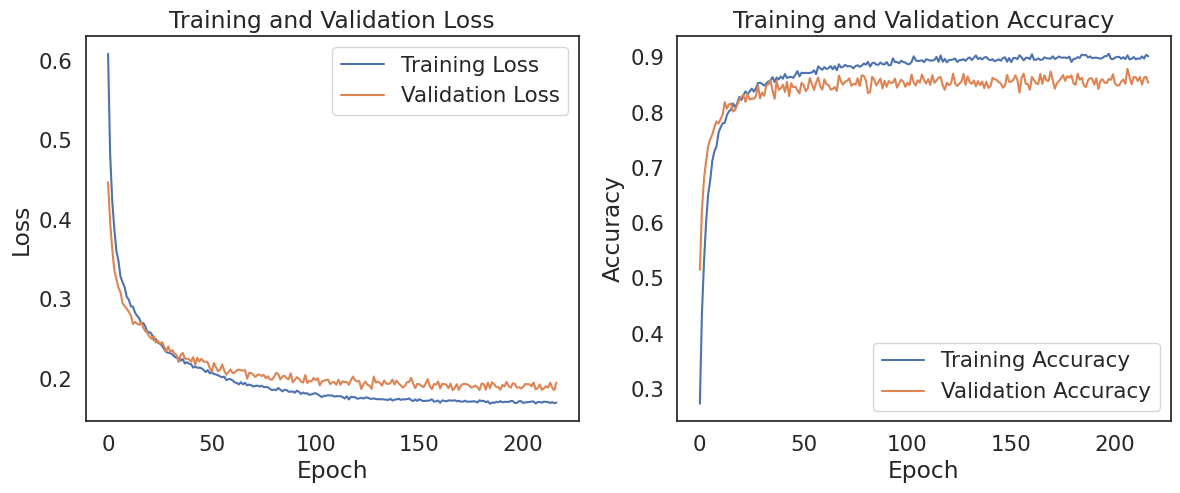

Epoch 217 : Learning rate = 1.2469375576529274e-07
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - categorical_accuracy: 0.9046 - loss: 0.1691 - val_categorical_accuracy: 0.8538 - val_loss: 0.1948


In [22]:
# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=callbacks
).history

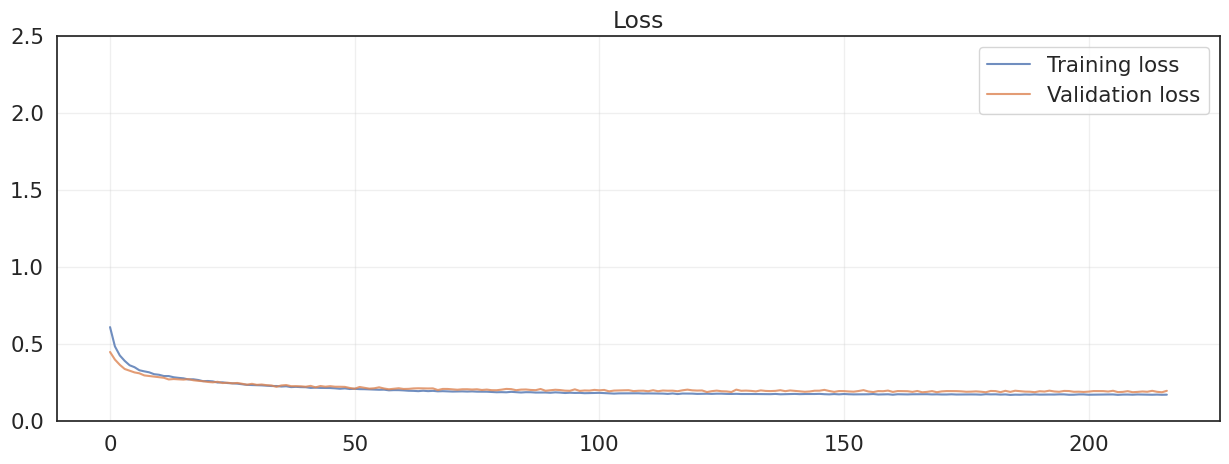

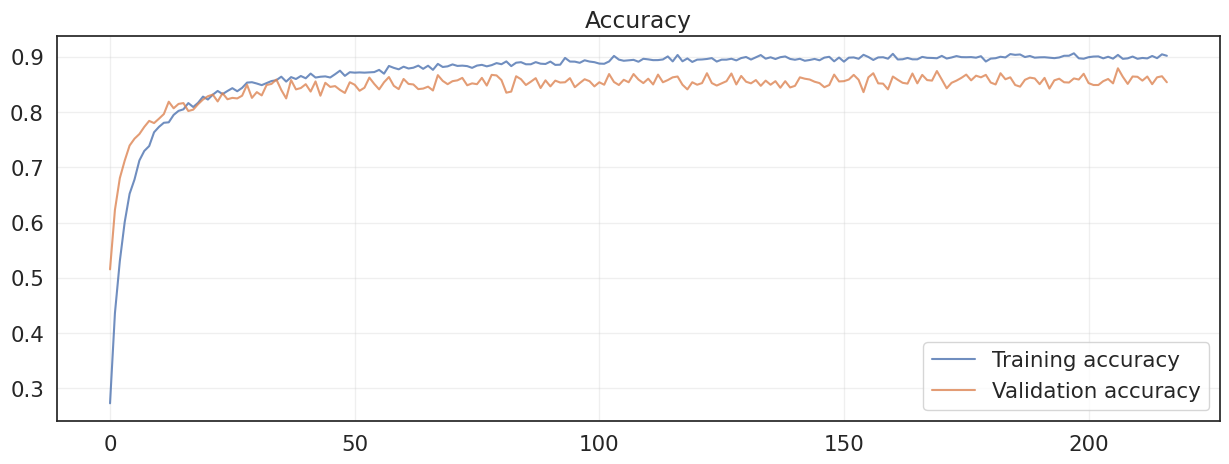

In [23]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.ylim(top=2.5, bottom=0.0)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 5))
plt.plot(history['categorical_accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'LION_ADAM_HEAVY_AUG_MODEL.weights.h5'
    model.save_weights(model_weights_filename)

In [25]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
def evaluations(model, ds, y_ds, labels, name):
    # Predict class probabilities and get predicted classes
    ds_predictions = model.predict(ds, verbose=0)
    ds_predictions = np.argmax(ds_predictions, axis=-1)
    
    # Extract ground truth classes
    ds_gt = np.argmax(y_ds, axis=-1)
    
    # Calculate and display training set accuracy
    ds_accuracy = accuracy_score(ds_gt, ds_predictions)
    print(f'Accuracy score over the {name} set: {round(ds_accuracy, 4)}')
    
    # Calculate and display training set precision
    ds_precision = precision_score(ds_gt, ds_predictions, average='weighted')
    print(f'Precision score over the {name} set: {round(ds_precision, 4)}')
    
    # Calculate and display training set recall
    ds_recall = recall_score(ds_gt, ds_predictions, average='weighted')
    print(f'Recall score over the {name} set: {round(ds_recall, 4)}')
    
    # Calculate and display training set F1 score
    ds_f1 = f1_score(ds_gt, ds_predictions, average='weighted')
    print(f'F1 score over the {name} set: {round(ds_f1, 4)}')
    
    # Compute the confusion matrix
    cm = confusion_matrix(ds_gt, ds_predictions)
    
    # Create labels combining confusion matrix values
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
    
    # Plot the confusion matrix with class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

2024-11-23 20:09:45.240434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node TF-CNN_1/BatchNorm_After_ConvNeXt_1/Cast_1/ReadVariableOp.


I0000 00:00:1732392585.838554     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7f76491aa4c499ba:0:0), session_name()


I0000 00:00:1732392592.463234     822 tpu_compile_op_common.cc:245] Compilation of 7f76491aa4c499ba:0:0 with session name  took 6.624631791s and succeeded
I0000 00:00:1732392592.483073     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7f76491aa4c499ba:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2962778086988661471", property.function_library_fingerprint = 5732486756251199620, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732392592.483106     822 tpu_compilation_cache_interface.cc:541] After adding entry for key 7f76491aa4c4

I0000 00:00:1732392619.502386     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a4a2d8b599bf3404:0:0), session_name()


I0000 00:00:1732392625.131481     814 tpu_compile_op_common.cc:245] Compilation of a4a2d8b599bf3404:0:0 with session name  took 5.629048708s and succeeded
I0000 00:00:1732392625.150529     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a4a2d8b599bf3404:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_18186959172349764059", property.function_library_fingerprint = 14085350286258900975, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732392625.150560     814 tpu_compilation_cache_interface.cc:541] After adding entry for key

Accuracy score over the validation set: 0.8564
Precision score over the validation set: 0.8568
Recall score over the validation set: 0.8564
F1 score over the validation set: 0.8566


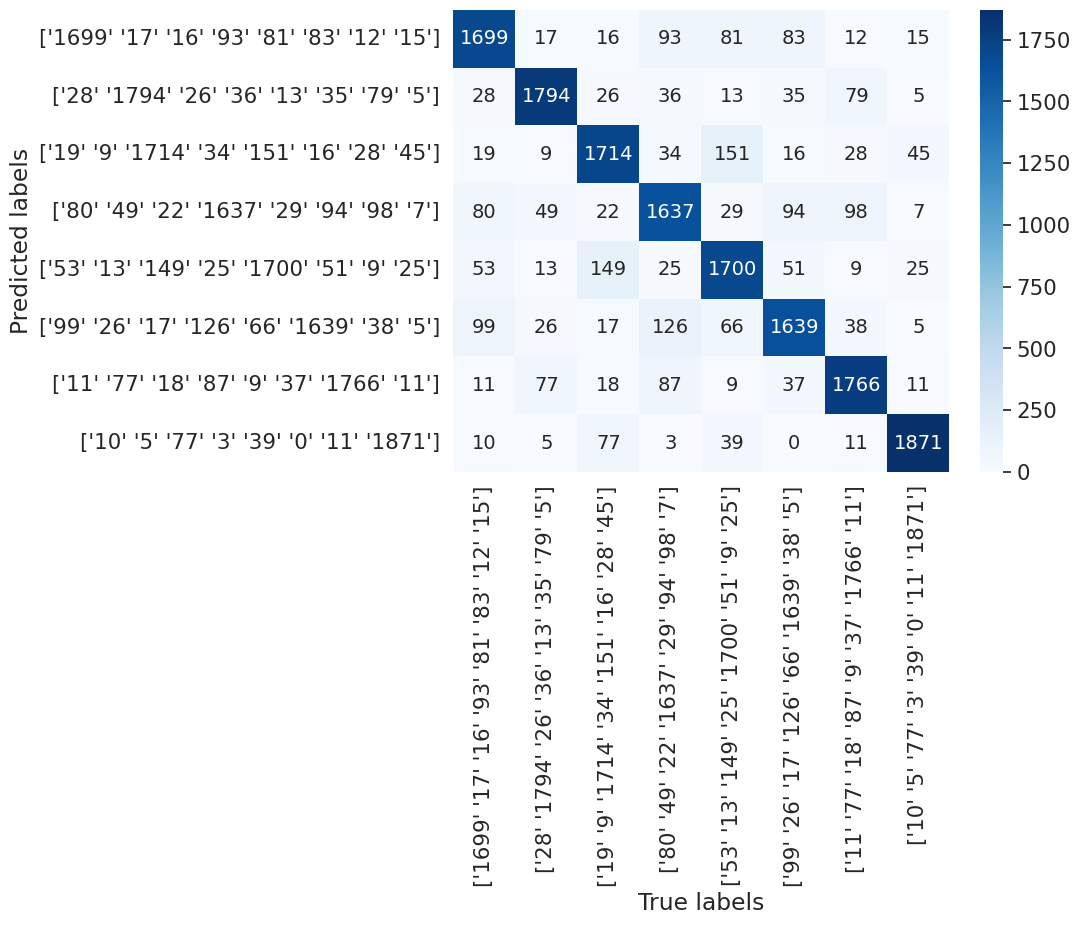

In [27]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')

In [28]:
# Get the weights of the last two dense layers and the output layer
dense_layer_1_weights = model.get_layer('Dense_layer_0').get_weights()
dense_layer_2_weights = model.get_layer('Dense_layer_1').get_weights()
dense_layer_3_weights = model.get_layer('Dense_layer_2').get_weights()
output_layer_weights = model.get_layer('output_layer').get_weights()

# Save the weights to files
np.savez('dense_layer_1_weights.npz', *dense_layer_1_weights)
np.savez('dense_layer_2_weights.npz', *dense_layer_2_weights)
np.savez('dense_layer_3_weights.npz', *dense_layer_3_weights)
np.savez('output_layer_weights.npz', *output_layer_weights)

## Fine tunning

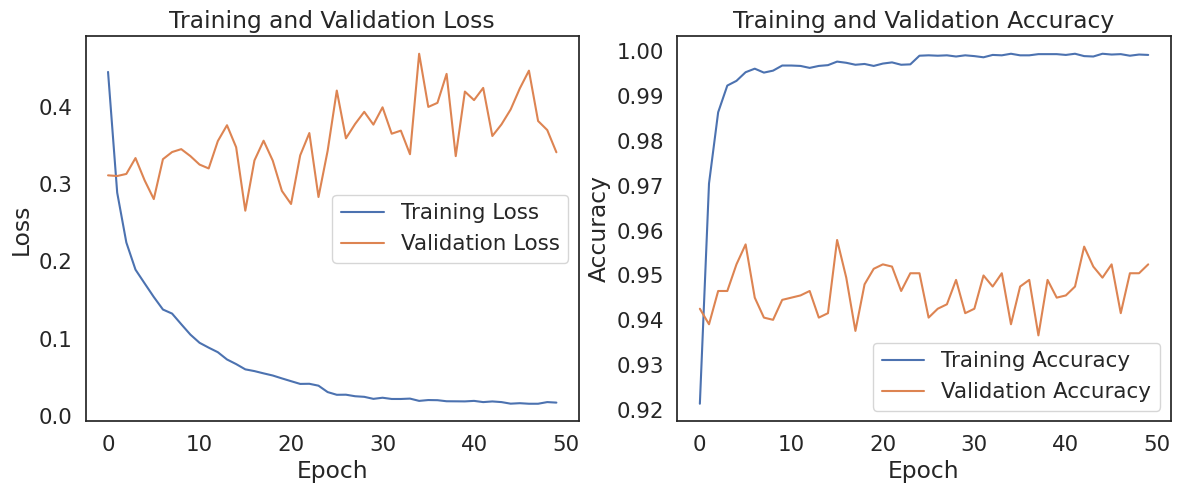

Epoch 50 : Learning rate = 4.999999873689376e-06
357/357 ━━━━━━━━━━━━━━━━━━━━ 64s 179ms/step - categorical_accuracy: 0.9992 - loss: 0.0154 - val_categorical_accuracy: 0.9524 - val_loss: 0.3416


In [29]:
model.get_layer('convnext_xlarge').trainable = True  # Base model

# Unfreeze only specific layers
trainable_layers_count = 0
for layer in model.get_layer('convnext_xlarge').layers:
    if 'stage_4' in layer.name or 'stage_3' in layer.name or 'stage_2' in layer.name  :  # Adjust based on architecture
        layer.trainable = True
        trainable_layers_count+=1
    else:
        layer.trainable = False

print(trainable_layers_count)

# Replace Dropout layers with higher rates
def increase_dropout(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = new_rate
    return model

model = increase_dropout(model, new_rate=0.5)

with strategy.scope():
    # Recompile with weight decay
    model.compile(
        optimizer=tf.keras.optimizers.Lion(
                                    learning_rate=1e-5,
                                    beta_1=0.9,
                                    beta_2=0.99,
                                    use_ema=False,
                                    ema_momentum=0.99,
                                    weight_decay=1e-3,
                                    name="lion"
                                ), 
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=callbacks
)

In [30]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'LION_FINE_ADAM_HEAVY_AUG_MODEL.weights.h5'
    model.save_weights(model_weights_filename)

2024-11-23 21:05:42.075736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node TF-CNN_1/BatchNorm_After_ConvNeXt_1/Cast_1/ReadVariableOp.


I0000 00:00:1732395942.656421     888 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b26053ac7a334f9d:0:0), session_name()


I0000 00:00:1732395949.101972     888 tpu_compile_op_common.cc:245] Compilation of b26053ac7a334f9d:0:0 with session name  took 6.44547842s and succeeded
I0000 00:00:1732395949.128928     888 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b26053ac7a334f9d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3966646422575105375", property.function_library_fingerprint = 14200349815015095123, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732395949.128966     888 tpu_compilation_cache_interface.cc:541] After adding entry for key b26053ac7a33

I0000 00:00:1732395978.892058     895 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c1262e8d0e6621a4:0:0), session_name()


I0000 00:00:1732395984.940001     895 tpu_compile_op_common.cc:245] Compilation of c1262e8d0e6621a4:0:0 with session name  took 6.047893024s and succeeded
I0000 00:00:1732395984.964286     895 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c1262e8d0e6621a4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11487465465225235789", property.function_library_fingerprint = 13072585235569042254, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732395984.964320     895 tpu_compilation_cache_interface.cc:541] After adding entry for key

Accuracy score over the validation set: 0.9362
Precision score over the validation set: 0.9364
Recall score over the validation set: 0.9362
F1 score over the validation set: 0.9362


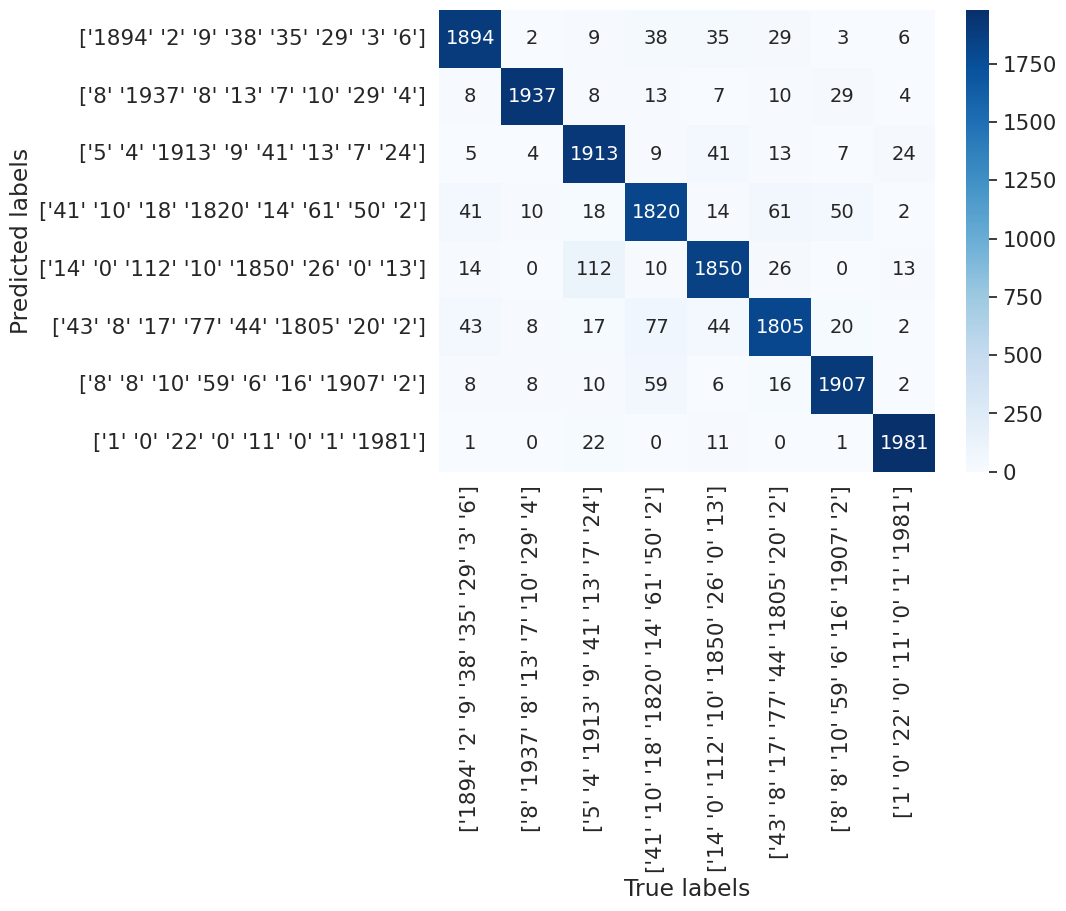

In [31]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')